In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint

from SVD import Metrics, SVDPredictor, LogisticSVD
from RecData import RecData

In [2]:
recs = pd.read_csv('data/pruned.csv')
USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

recs.head()

,app_id,is_recommended,user_id
0,534380,True,10531
1,42700,False,185293
2,602960,True,319249
3,976730,False,747545
4,1091500,True,2113544


In [3]:
random.seed(42)
np.random.seed(42)

rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

train_data, test = rec_data.leave_k_out_split(k=2)
train_data, val = train_data.leave_k_out_split(k=2)

Epoch 0/Training error: 0.6931213749829699/Validation error: 0.6931474671946463/Time: 58.86 seconds
Epoch 1/Training error: 0.6930838846019972/Validation error: 0.6931419298467049/Time: 59.36 seconds
Epoch 2/Training error: 0.6929903463354747/Validation error: 0.6931039517579008/Time: 58.87 seconds
Epoch 3/Training error: 0.6925912654337834/Validation error: 0.6928588775460471/Time: 72.62 seconds
Epoch 4/Training error: 0.6903693630322072/Validation error: 0.691304276610565/Time: 60.73 seconds
Epoch 5/Training error: 0.6778702796738639/Validation error: 0.6821012421194463/Time: 61.49 seconds
Epoch 6/Training error: 0.628641064433206/Validation error: 0.6431195206320527/Time: 80.43 seconds
Epoch 7/Training error: 0.5437455746681131/Validation error: 0.5683782521980605/Time: 71.4 seconds
Epoch 8/Training error: 0.4746856195424619/Validation error: 0.5032623455856071/Time: 59.25 seconds
Epoch 9/Training error: 0.4321364355234836/Validation error: 0.4631514293044296/Time: 57.95 seconds
Epo

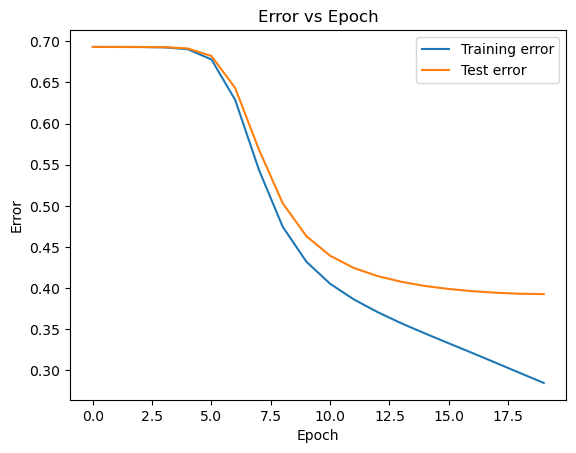

Test rmse 1.065328749353946
Saving model...
Done saving model.


In [24]:
EPOCHS = 20

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = LogisticSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=50, epochs=EPOCHS, 
    learning_rate=0.01, C=0.04)
svd_predictor.fit(train_data.get_matrix(), validation_set=val)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([svd_predictor, rec_data, train_data, val, test], file)
print("Done saving model.")

In [ ]:
svd_predictor._user_biases[11, 0]

In [42]:
j = 0
# Test top-n list for user j
top_n = svd_predictor.top_n(j, 20)
print("Predicted top n:")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

# User j true top n list
print("True top n:")
true_top = rec_data.top_n(j, 5000)
pprint([rec_data.index_to_title(index) for _, index in true_top])

Predicted top n:
[(0.9992866682243948, 'Wallpaper Engine'),
 (0.9987035508208278, 'Left 4 Dead 2'),
 (0.9984746344038841, 'Portal'),
 (0.9983337969492656, 'Half-Life: Alyx'),
 (0.9979956809030099, 'Resident Evil 2'),
 (0.9978784865706751, 'Portal 2'),
 (0.997786339663304, 'Divinity: Original Sin 2 - Definitive Edition'),
 (0.9977841283594094, 'Slay the Spire'),
 (0.997571995087821, "Garry's Mod"),
 (0.9973467264337281, 'Terraria'),
 (0.9973119747652951, 'Dishonored'),
 (0.9971549337452125, 'Vampire Survivors'),
 (0.9970573990813131, 'The Binding of Isaac: Rebirth'),
 (0.9969190440696292, 'DOOM'),
 (0.9967883501989653, 'Papers Please'),
 (0.9967414566275917, 'ULTRAKILL'),
 (0.9964935833855385, 'Factorio'),
 (0.9963444029948927, 'Inscryption'),
 (0.9962613347318281, 'Deep Rock Galactic'),
 (0.9962099509739756, 'Resident Evil Village')]
True top n:
['Grand Theft Auto IV: The Complete Edition',
 'Fallout: New Vegas',
 'Dying Light',
 '7 Days to Die',
 'American Truck Simulator',
 'RimWorld

In [38]:
rec_data.search_title('portal')

[('portal 2', 11), ('desktop portal', 1582), ('portal', 6)]

In [39]:
prefs = [(606, 1), (1628, 1), (391, 0), (1330, 0), (500, 0), (709, 1), (840, 0), 
         (58, 1), (456, 1), (153, 0), (158, 0), (1160, 0), (761, 0),
                              (1771, 0), (544, 0), (312, 0), (277, 0)]
pprint([(index, rec_data.index_to_title(index), pref) for index, pref in prefs])
prefs = rec_data.create_prefs(prefs)    

[(606, 'Stardew Valley', 1),
 (1628, 'The Sims™ 4', 1),
 (391, 'Mortal Kombat X', 0),
 (1330, 'Mortal Kombat\xa011', 0),
 (500, 'Total War: WARHAMMER', 0),
 (709, 'UNO', 1),
 (840, 'MONOPOLY® PLUS', 0),
 (58, 'SPORE™', 1),
 (456, 'Choice of Robots', 1),
 (153, 'Infested Planet', 0),
 (158, 'Gunpoint', 0),
 (1160, 'Cosmoteer: Starship Architect & Commander', 0),
 (761, 'Glass Masquerade', 0),
 (1771, 'Against the Storm', 0),
 (544, 'Aviary Attorney', 0),
 (312, 'Grand Theft Auto V', 0),
 (277, 'Rust', 0)]


In [40]:
svd_predictor._partial_batch_size = int(0)
start_time = time.time()
svd_predictor.partial_fit(prefs)
print("Completed partial fit in", time.time() - start_time, "seconds")

AttributeError: 'LogisticSVD' object has no attribute '_user_biases'

In [23]:
top_n = svd_predictor.top_n(train_data.get_matrix().shape[0], 20)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

Predicted top n
[(0.9908499777686517, 'eFootball™ 2023'),
 (0.9814174079790924, 'Battlefield™ 2042'),
 (0.972738549814746, 'Rugby 22'),
 (0.9691302801641789, 'PUBG: BATTLEGROUNDS'),
 (0.9678884481501989, 'Z1 Battle Royale'),
 (0.9630763549674729, 'BIOMUTANT'),
 (0.9627740839451867, 'ICARUS'),
 (0.9619426469797, 'Might & Magic X - Legacy'),
 (0.9611264122200068, "Assassin's Creed Valhalla"),
 (0.9608861532025795, 'End State'),
 (0.9553479142064581, 'Another Farm Roguelike'),
 (0.947986676641079, 'Arcade Spirits: The New Challengers'),
 (0.9468602401406665, 'Back 4 Blood'),
 (0.943875484980961, 'Trackmania® Turbo'),
 (0.9369798273136265, 'Generation Zero®'),
 (0.935710298813653, 'ATLAS'),
 (0.9355139991920496, 'Fhtagn Simulator'),
 (0.9259984095767555, 'FOR HONOR™'),
 (0.9204974604784083, 'Animalia Survival'),
 (0.9186543313705807, 'Silent Hill Homecoming')]
